In [28]:
from spikeA.Dat_file_reader import Dat_file_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [5]:
def get_lfp_spectrogram(file_names, start_sample, end_sample, n_channels, channels, spec_file, sampling_rate = 20000, nperseg=2**17, overwrite=False):
    """
        Method to get the LFP spectrogram (power vs. frequency). It saves the data into a file and returns them.
        
        Arguments:
        file_names: trials to use
        start_sample, end_sample: samples from which and to which to take into account
        n_channels: number of channels in the recording
        channel: channels for which to calculate the spectrogram
        sampling rate: sampling rate of dat file (in Hz)
        nperseg: defines the resolution in the welch function
        overwrite: set True to overwrite the saved file.
        
        Return:
        array with frequency as first column and channels as other columns  
    """
    import os.path
    import numpy as np
    
    if not os.path.exists(spec_file) or overwrite==True:
        from spikeA.Dat_file_reader import Dat_file_reader
        from scipy.signal import welch
        from scipy.ndimage import gaussian_filter1d

        # read the data from the selected dat file for the selected channels
        df = Dat_file_reader(file_names=file_names, n_channels=n_channels)
        data = df.get_data_one_block(start_sample=start_sample, end_sample=end_sample, channels=np.asarray(channels))



        for i,j in enumerate(channels):
            data_1_channel = data[i,:]
            f, signal = welch(data_1_channel, fs=sampling_rate, nperseg=nperseg, scaling='spectrum')

            if i==0:
                # create an array to store the data and insert f as first column
                array = np.empty((signal.shape[0],len(channels)+1),float)
                array[:,0] = f
            array[:,i+1]=signal

        np.save(file = spec_file, arr = array)

    else:
        array = np.load(spec_file)
        
    return array

In [17]:
def detect_theta_peak(f, signal, theta_range=[4,12], peak_range=[2,2], peak_height='90%theta_max', peak_distance='0.5Hz'):
    """
        Method to find the peak frequency within theta range and calculate some theta properties
        
        Arguments:
        f: frequency (fft of time)
        signal: power (fft of signal)
        theta_range: range within the peak should be found
        peak_range: range around the peak which should be considered for theta power calculation and peak width calculation
        peak_height: required height for the peak to be detected
        peak_distance: required distance between detected peaks
        
        Return:
        theta peak frequency (in Hz), power at peak frequency, theta power, width at full height, width at half height 
    """
    
    import numpy as np
    from scipy.signal import find_peaks, peak_widths, peak_prominences
    from scipy import integrate
    
    # cut the signal and frequency to the theta range
    theta_signal = [j for i,j in enumerate(signal) if f[i]>theta_range[0] and f[i]<theta_range[1]]
    theta_freq = [j for i,j in enumerate(f) if j>theta_range[0] and j<theta_range[1]]
    
    if peak_height == '90%theta_max':
        peak_height = np.max(theta_signal)*0.9
    if peak_distance == '0.5Hz':
        peak_distance = len(theta_freq)/(theta_range[1]-theta_range[0])/2
    
    # detect the theta peak
    peak = find_peaks(theta_signal, height=peak_height, distance=peak_distance)

    # determine theta properties if peak was detected
    if peak[0].size>0:
        # select peak with highest power if several have been found
        if len(peak[0])>1:
            print('found more than 1 peak')
            max_power = np.nanmax([int(peak[1].get('peak_heights')[i]) for i,j in enumerate(peak[0])])
            peak_index_list = list(np.where([int(peak[1].get('peak_heights')[i]) for i,j in enumerate(peak[0])]==max_power))
            if len(peak_index_list[0])>1:
                peak_index_list[0] = peak_index_list[0][1:]
            peak_index = peak_index_list
            peak_freq_sample = peak[0][peak_index]
            peak_power = int(peak[1].get('peak_heights')[peak_index])
            peak_freq = theta_freq[int(peak[0][peak_index])]
        else:
            peak_freq_sample = peak[0]
            peak_power = int(peak[1].get('peak_heights'))
            peak_freq = theta_freq[int(peak[0])]

        # calculate the prominence of the peak taking a window given by peak_range
        prominence_data = peak_prominences(theta_signal, peak_freq_sample, wlen=float((peak_range[0]+peak_range[1])*peak_freq_sample/(peak_freq-theta_range[0])))

        # get the width of the peak at full height and half height
        width_full = peak_widths(theta_signal, peak_freq_sample, prominence_data=prominence_data, rel_height=1)
        width_half = peak_widths(theta_signal, peak_freq_sample, prominence_data=prominence_data, rel_height=0.5)

        peak_width_full = (peak_freq-theta_range[0])/peak_freq_sample*width_full[0] #convert from sample to frequency
        peak_width_half = (peak_freq-theta_range[0])/peak_freq_sample*width_half[0]

        # to get the theta power, take the ratio of power around the theta peak and at lower and higher frequencies
        baseline1 = [peak_freq-2*peak_range[0],peak_freq-peak_range[0]]; baseline2 = [peak_freq+peak_range[1],peak_freq+2*peak_range[1]]
        theta = [peak_freq-peak_range[0],peak_freq+peak_range[1]]
        signal_baseline1 = [j for i,j in enumerate(signal) if f[i]>baseline1[0] and f[i]<baseline1[1]]
        f_baseline1 = [j for i,j in enumerate(f) if f[i]>baseline1[0] and f[i]<baseline1[1]]
        area_baseline1 = integrate.simpson(signal_baseline1, f_baseline1)

        signal_baseline2 = [j for i,j in enumerate(signal) if f[i]>baseline2[0] and f[i]<baseline2[1]]
        f_baseline2 = [j for i,j in enumerate(f) if f[i]>baseline2[0] and f[i]<baseline2[1]]
        area_baseline2 = integrate.simpson(signal_baseline2, f_baseline2)

        area_baseline = area_baseline1+area_baseline2

        signal_theta = [j for i,j in enumerate(signal) if f[i]>theta[0] and f[i]<theta[1]]
        f_theta = [j for i,j in enumerate(f) if f[i]>theta[0] and f[i]<theta[1]]
        area_theta = integrate.simpson(signal_theta, f_theta)

        theta_power = area_theta/area_baseline
    else:
        peak_freq = peak_power = theta_power = peak_width_full = peak_width_half = np.nan


    return (peak_freq, peak_power, theta_power, peak_width_full, peak_width_half)

In [22]:
def detect_theta_peak(f, signal, theta_range=[4,12], peak_range=[2,2], peak_height='90%theta_max', peak_distance='0.5Hz', sigma=1.5):
    """
        Method to find the peak frequency within theta range and calculate some theta properties
        
        Arguments:
        f: frequency (fft of time)
        signal: power (fft of signal)
        theta_range: range within the peak should be found
        peak_range: range around the peak which should be considered for theta power calculation and peak width calculation
        peak_height: required height for the peak to be detected
        peak_distance: required distance between detected peaks
        sigma: Gaussian kernel to smooth the signal before detecting the peak
        
        Return:
        theta peak frequency (in Hz), power at peak frequency, theta power, width at full height, width at half height 
    """
    
    import numpy as np
    from scipy.signal import find_peaks, peak_widths, peak_prominences
    from scipy import integrate
    from scipy.ndimage import gaussian_filter1d 
    
    if sigma:
        signal = gaussian_filter1d(signal, sigma=sigma)
    
    # cut the signal and frequency to the theta range
    theta_signal = [j for i,j in enumerate(signal) if f[i]>theta_range[0] and f[i]<theta_range[1]]
    theta_freq = [j for i,j in enumerate(f) if j>theta_range[0] and j<theta_range[1]]
    
    if peak_height == '90%theta_max':
        peak_height = np.max(theta_signal)*0.9
    if peak_distance == '0.5Hz':
        peak_distance = len(theta_freq)/(theta_range[1]-theta_range[0])/2
    
    # detect the theta peak
    peak = find_peaks(theta_signal, height=peak_height, distance=peak_distance)

    # determine theta properties if peak was detected
    if peak[0].size>0:
        # select peak with highest power if several have been found
        if len(peak[0])>1:
            print('found more than 1 peak')
            max_power = np.nanmax([int(peak[1].get('peak_heights')[i]) for i,j in enumerate(peak[0])])
            peak_index_list = list(np.where([int(peak[1].get('peak_heights')[i]) for i,j in enumerate(peak[0])]==max_power))
            if len(peak_index_list[0])>1:
                peak_index_list[0] = peak_index_list[0][1:]
            peak_index = peak_index_list
            peak_freq_sample = peak[0][tuple(peak_index)]
            peak_power = int(peak[1].get('peak_heights')[tuple(peak_index)])
            peak_freq = theta_freq[int(peak[0][tuple(peak_index)])]
        else:
            peak_freq_sample = peak[0]
            peak_power = int(peak[1].get('peak_heights'))
            peak_freq = theta_freq[int(peak[0])]

        # calculate the prominence of the peak taking a window given by peak_range
        prominence_data = peak_prominences(theta_signal, peak_freq_sample, wlen=float((peak_range[0]+peak_range[1])*peak_freq_sample/(peak_freq-theta_range[0])))

        # get the width of the peak at full height and half height
        width_full = peak_widths(theta_signal, peak_freq_sample, prominence_data=prominence_data, rel_height=1)
        width_half = peak_widths(theta_signal, peak_freq_sample, prominence_data=prominence_data, rel_height=0.5)

        peak_width_full = (peak_freq-theta_range[0])/peak_freq_sample*width_full[0] #convert from sample to frequency
        peak_width_half = (peak_freq-theta_range[0])/peak_freq_sample*width_half[0]

        # to get the theta power, take the ratio of power around the theta peak and at lower and higher frequencies
        baseline1 = [peak_freq-2*peak_range[0],peak_freq-peak_range[0]]; baseline2 = [peak_freq+peak_range[1],peak_freq+2*peak_range[1]]
        theta = [peak_freq-peak_range[0],peak_freq+peak_range[1]]
        signal_baseline1 = [j for i,j in enumerate(signal) if f[i]>baseline1[0] and f[i]<baseline1[1]]
        f_baseline1 = [j for i,j in enumerate(f) if f[i]>baseline1[0] and f[i]<baseline1[1]]
        area_baseline1 = integrate.simpson(signal_baseline1, f_baseline1)

        signal_baseline2 = [j for i,j in enumerate(signal) if f[i]>baseline2[0] and f[i]<baseline2[1]]
        f_baseline2 = [j for i,j in enumerate(f) if f[i]>baseline2[0] and f[i]<baseline2[1]]
        area_baseline2 = integrate.simpson(signal_baseline2, f_baseline2)

        area_baseline = area_baseline1+area_baseline2

        signal_theta = [j for i,j in enumerate(signal) if f[i]>theta[0] and f[i]<theta[1]]
        f_theta = [j for i,j in enumerate(f) if f[i]>theta[0] and f[i]<theta[1]]
        area_theta = integrate.simpson(signal_theta, f_theta)

        theta_power = area_theta/area_baseline
    else:
        peak_freq = peak_power = theta_power = peak_width_full = peak_width_half = np.nan


    return (peak_freq, peak_power, theta_power, peak_width_full, peak_width_half)

In [35]:
mouse="bt8564"
date="23072021"
name=f"{mouse}-{date}-0105"
path=f"/adata/electro/{mouse}/{name}/"

Get the spectrogram of the first trial from channels 0 and 1.

In [36]:
df = Dat_file_reader(file_names=[f"{path}{mouse}-{date}_01.dat"], n_channels=65)
first, last = df.get_first_last_samples_each_file()
array = get_lfp_spectrogram(file_names=[f"{path}{mouse}-{date}_01.dat"], start_sample=int(first), end_sample=int(last), n_channels=65, channels=[n for n in range(65)], spec_file=f"{path}spec_01.npy", overwrite=False)

Find the theta peak for channel 0.

In [37]:
array = np.load(f"{path}spec_01.npy")
f=array[:,0]
channel0=array[:,1]
peak_freq,peak_power, theta_power, peak_width_full, peak_width_half = detect_theta_peak(f=f,signal=channel0)

Plot the result.

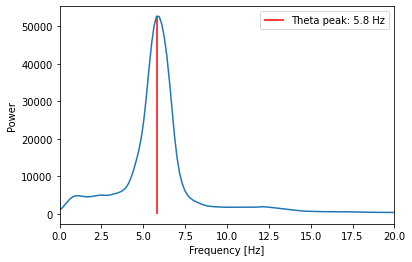

In [38]:
signal = gaussian_filter1d(channel0, sigma=1.5)
plt.plot(f, signal)
plt.xlim(0,20)
label = f"Theta peak: {peak_freq:.3} Hz"
plt.vlines(peak_freq, ymin=0, ymax=peak_power, colors='red', label=label)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.legend()
plt.show()

In [11]:
print(f"Theta power: {theta_power:.3}\nWidth at full height: {float(peak_width_full):.3}\nWidth at half height: {float(peak_width_half):.3}")

Theta power: 8.09
Width at full height: 4.05
Width at half height: 1.21
